# Evaluating and Diagnosing Stochastic Gradient MCMC


In this project we are interested in estimating convergence properties of Stochastic Gradient MCMC algorithms (SG-MCMC). These algorithms are well known for efficiently computing posterior estimates when the data set does not fit into memory (out-of-core), however the estimates tend to be biased.

One such approach is the Stochastic Gradient Langevin Dynamics (SGLD) sampler, which makes use of a Langevin diffusion to approximate the costly gradient and likelihood evaluations using a mini-batch of the data.

The SGLD algorithm produces aymptotically biased posterior estimates and therefore it is not straightforward to assess convergence of the underlying Markov chain [1]. Therefore, in this project we are interested in comparing standard diagnostic tools such as  𝑅̂   and  𝑁𝑒𝑓𝑓  of SGLD for a model with hierarchical priors and a model with a flat prior.

[1] Christopher Nemeth & Paul Fearnhead (2021) Stochastic Gradient Markov Chain Monte Carlo, Journal of the American Statistical Association, 116:533, 433-450, DOI: 10.1080/01621459.2020.1847120

In [1]:
import sys
sys.path.append("../") 

In [3]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

## Dataset

We consider a multi-class OCR digits classification problem. The MNIST dataset consists of $70000$ labeled data points test points, each one consisting of $28 \times 28$ grayscale pixels. 

![MNIST Examples](MnistExamples.png)


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [5]:
num_gpus = 0
model_ctx = mx.gpu()

num_workers = 0
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
for X,y in val_data:
    print(type(X))
    print(X.shape)
    print(y.shape)
    break

<class 'mxnet.numpy.ndarray'>
(256, 1, 28, 28)
(256,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

The data set contains tuples $(x_i,y_i)$, where $x_i \in \mathbb R^{784}$ and $y \in \{0,1,2,\ldots\,9\}$. The model estimate the probability of example $i$ belonging to one of the 10 classes, as follows: 

$\hat y_i = \frac{\exp(o_i)}{\sum_k \exp(o_k)}$

Conversely, the observed data is transformed using a linear transformation $o_i= W^T \times x_i + b$. Therefore the model parameters are $\theta=(W,b)$ and the log-likelihood is:


$\ell(\theta) = \sum_{i=1}^{|D|} \sum_{j=0}^{10} \log \left( \frac{\exp(o_i)}{\sum_{k} \exp(o_k) } \right)^{I\{y^{(i)}=j\}}$

The priors for the first (non-hierarchical) model are set weakly informative $p(\theta)=p(W,b)=\prod_i^{784 \times 10} \text{normal}(0,10)\times \prod_i^{10} \text{normal}(0,10)$

In [9]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(1,28,28)
out_units=10

In [10]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [11]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

In [12]:
import matplotlib.pyplot as plt 
import h5py 

train_sgd=True
num_epochs=100
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_data,chain_name='mnist_map.h5',verbose=True)

    plt.rcParams['figure.dpi'] = 360
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('mnist_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()


  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [10]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       979
           1       0.98      0.97      0.97      1133
           2       0.93      0.88      0.90      1030
           3       0.88      0.90      0.89      1008
           4       0.91      0.93      0.92       980
           5       0.85      0.87      0.86       890
           6       0.91      0.95      0.93       956
           7       0.90      0.92      0.91      1027
           8       0.87      0.86      0.86       973
           9       0.92      0.86      0.89      1008

    accuracy                           0.91      9984
   macro avg       0.91      0.91      0.91      9984
weighted avg       0.91      0.91      0.91      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [11]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,par,step_size=0.001,ctx=model_ctx)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_nonhierarchical.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [13]:
import h5py 

posterior_samples=h5py.File('mnist_nonhierarchical.h5','r')

In [14]:
posterior_samples.attrs.keys()

<KeysViewHDF5 ['loss', 'num_chains', 'num_samples']>

In [15]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.89      0.91      0.90      1010
           4       0.90      0.93      0.91       982
           5       0.84      0.87      0.86       892
           6       0.92      0.93      0.93       958
           7       0.90      0.91      0.91      1028
           8       0.85      0.85      0.85       974
           9       0.92      0.86      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [16]:
posterior_samples['1.weight'].shape

(2, 100, 10, 784)

In [17]:
log_like.shape

(200, 10000)

In [18]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}

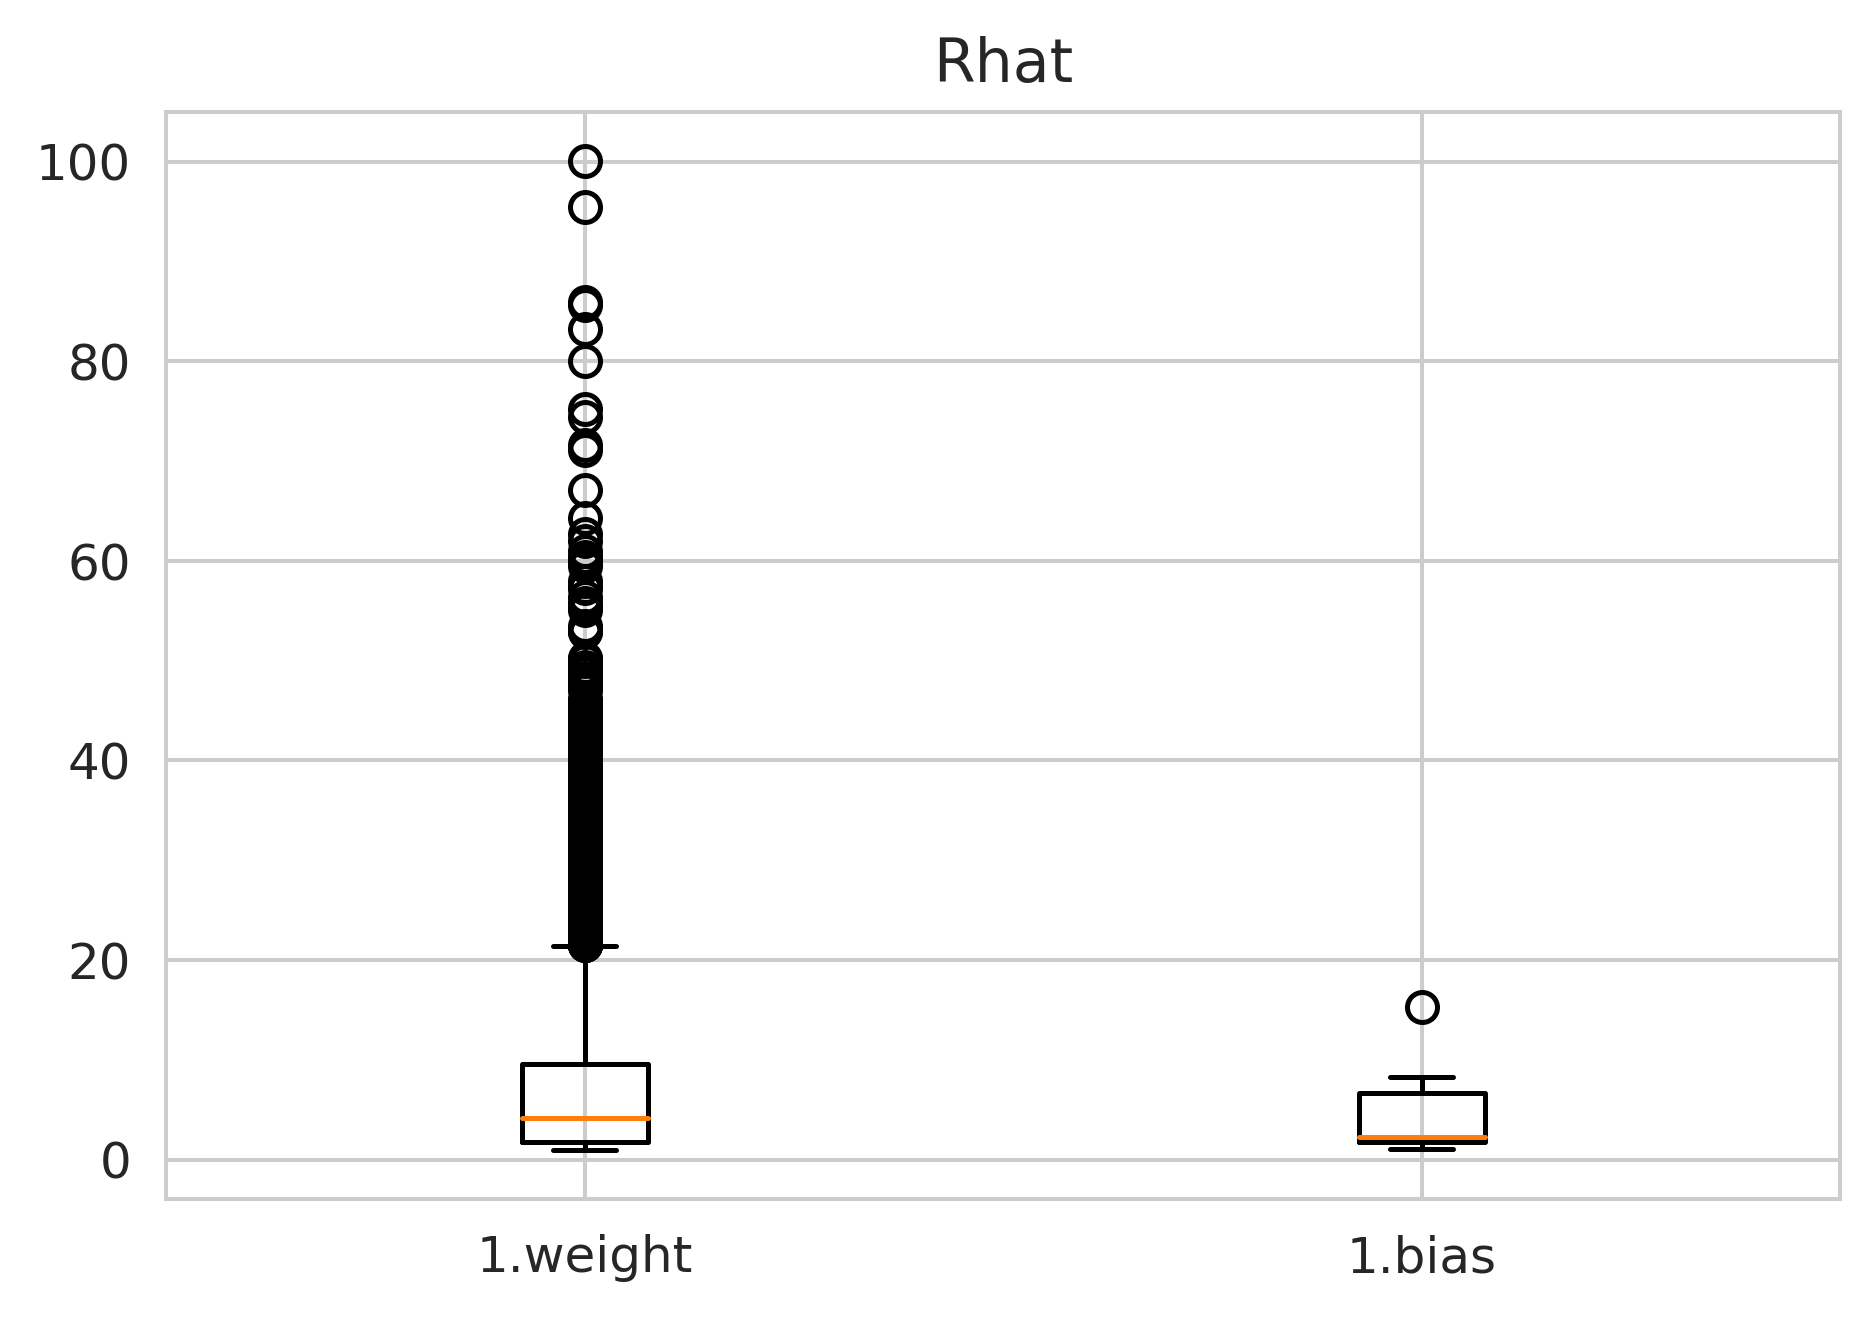

In [19]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_nonhierarchical_softmax.pdf', bbox_inches='tight')

In [20]:
median_rhat_flat={var:np.median(rhat[var]) for var in rhat}

In [21]:
median_rhat_flat

{'1.weight': 4.1469994, '1.bias': 2.2573416}

In [22]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}

In [23]:
median_ess_flat={var:np.median(ess[var]) for var in ess}

In [24]:
median_ess_flat

{'1.weight': 2.9541125, '1.bias': 4.086085}

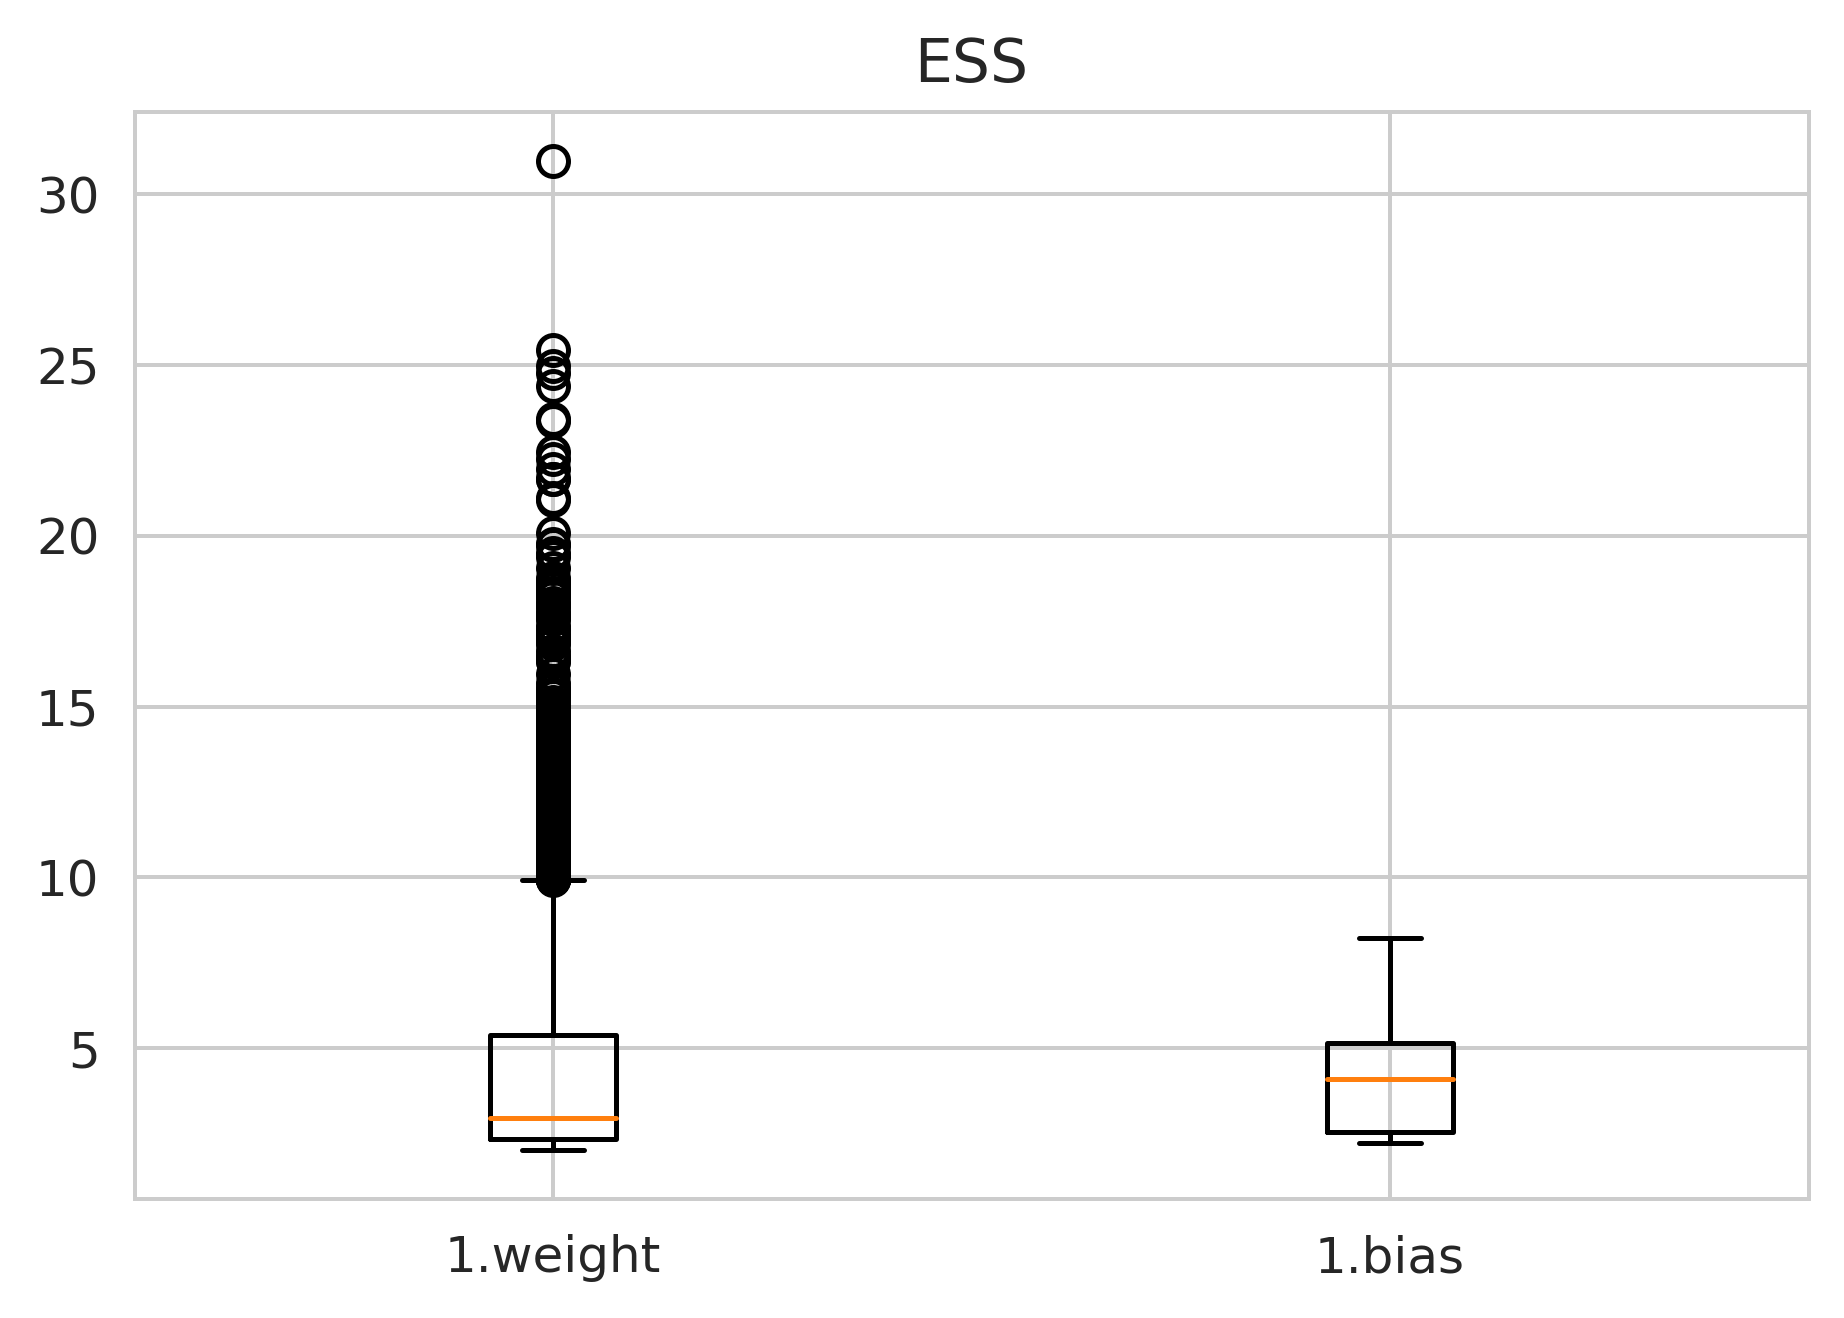

In [25]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_nonhierarchical_softmax.pdf', bbox_inches='tight')

In [26]:
#import dask.array as da 
#from hamiltonian.utils.diagnostics import potential_scale_reduction,effective_sample_size

#df=h5py.File('mnist_nonhierarchical.h5','r')
#samples={var:da.from_array(df[var]) for var in df.keys()}
#r_hat_estimate={var:potential_scale_reduction(samples[var]) for var in samples.keys()}
#ess_estimate={var:effective_sample_size(samples[var]) for var in samples.keys()}

In [27]:
flat_ks_1=np.sum(ks>1)

NameError: name 'ks' is not defined

In [ ]:
flat_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))

In [ ]:
flat_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))

In [ ]:
flat_ks_5=np.sum(ks<0.5)

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

An alternative hierarchical model considers a half normal distribution for the unkonwn scale parameter such as:

$p(\theta)=p(W,b)=\prod_i^{784 \times 10} \text{normal}(\mu_i,\sigma_i)\times \prod_j^{10} \text{normal}(\mu_j,\sigma_j)\times \prod_k^{784 \times 100} \text{normal}(0,1)\prod_k^{784 \times 100} \text{half_normal}(1)$



In [28]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import hierarchical_sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=hierarchical_sgld(model,par,step_size=0.001,ctx=model_ctx)

In [29]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [30]:
train_sgld=True
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_hierarchical.h5')



  1%|          | 1/100 [00:10<17:39, 10.70s/it]

loss: 10.6497


 11%|█         | 11/100 [02:04<17:03, 11.50s/it]

loss: 6.3396


 21%|██        | 21/100 [03:57<15:11, 11.53s/it]

loss: 4.9368


 31%|███       | 31/100 [05:47<12:31, 10.90s/it]

loss: 4.4448


 41%|████      | 41/100 [07:35<10:33, 10.74s/it]

loss: 4.1939


 51%|█████     | 51/100 [09:22<08:40, 10.63s/it]

loss: 3.9616


 61%|██████    | 61/100 [11:09<06:55, 10.66s/it]

loss: 3.8783


 71%|███████   | 71/100 [12:58<05:14, 10.83s/it]

loss: 3.8164


 81%|████████  | 81/100 [14:45<03:23, 10.70s/it]

loss: 3.8245


 91%|█████████ | 91/100 [16:33<01:37, 10.80s/it]

loss: 3.7647


  1%|          | 1/100 [00:10<17:36, 10.67s/it]

loss: 10.3985


 11%|█         | 11/100 [01:57<16:01, 10.80s/it]

loss: 5.9363


 21%|██        | 21/100 [03:53<15:50, 12.03s/it]

loss: 4.7317


 31%|███       | 31/100 [05:45<12:22, 10.75s/it]

loss: 4.2235


 41%|████      | 41/100 [07:35<10:51, 11.04s/it]

loss: 3.9829


 51%|█████     | 51/100 [09:24<08:36, 10.54s/it]

loss: 3.7685


 61%|██████    | 61/100 [11:08<06:43, 10.35s/it]

loss: 3.7193


 71%|███████   | 71/100 [12:52<04:59, 10.34s/it]

loss: 3.6434


 81%|████████  | 81/100 [14:35<03:16, 10.36s/it]

loss: 3.6371


 91%|█████████ | 91/100 [16:18<01:32, 10.31s/it]

loss: 3.6059


100%|██████████| 100/100 [17:51<00:00, 10.71s/it]


In [31]:
import h5py 

posterior_samples=h5py.File('mnist_hierarchical.h5','r')

In [32]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       980
           1       0.97      0.89      0.93      1135
           2       0.84      0.78      0.81      1032
           3       0.71      0.83      0.77      1010
           4       0.70      0.81      0.75       982
           5       0.61      0.70      0.65       892
           6       0.75      0.87      0.80       958
           7       0.68      0.88      0.77      1028
           8       0.79      0.60      0.68       974
           9       0.94      0.52      0.67      1009

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.77     10000
weighted avg       0.80      0.78      0.78     10000



In [33]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}

In [34]:
median_rhat_hierarchical={var:np.median(rhat[var]) for var in rhat}

In [35]:
median_rhat_hierarchical

{'1.weight': 1.2545099, '1.bias': 1.1949863}

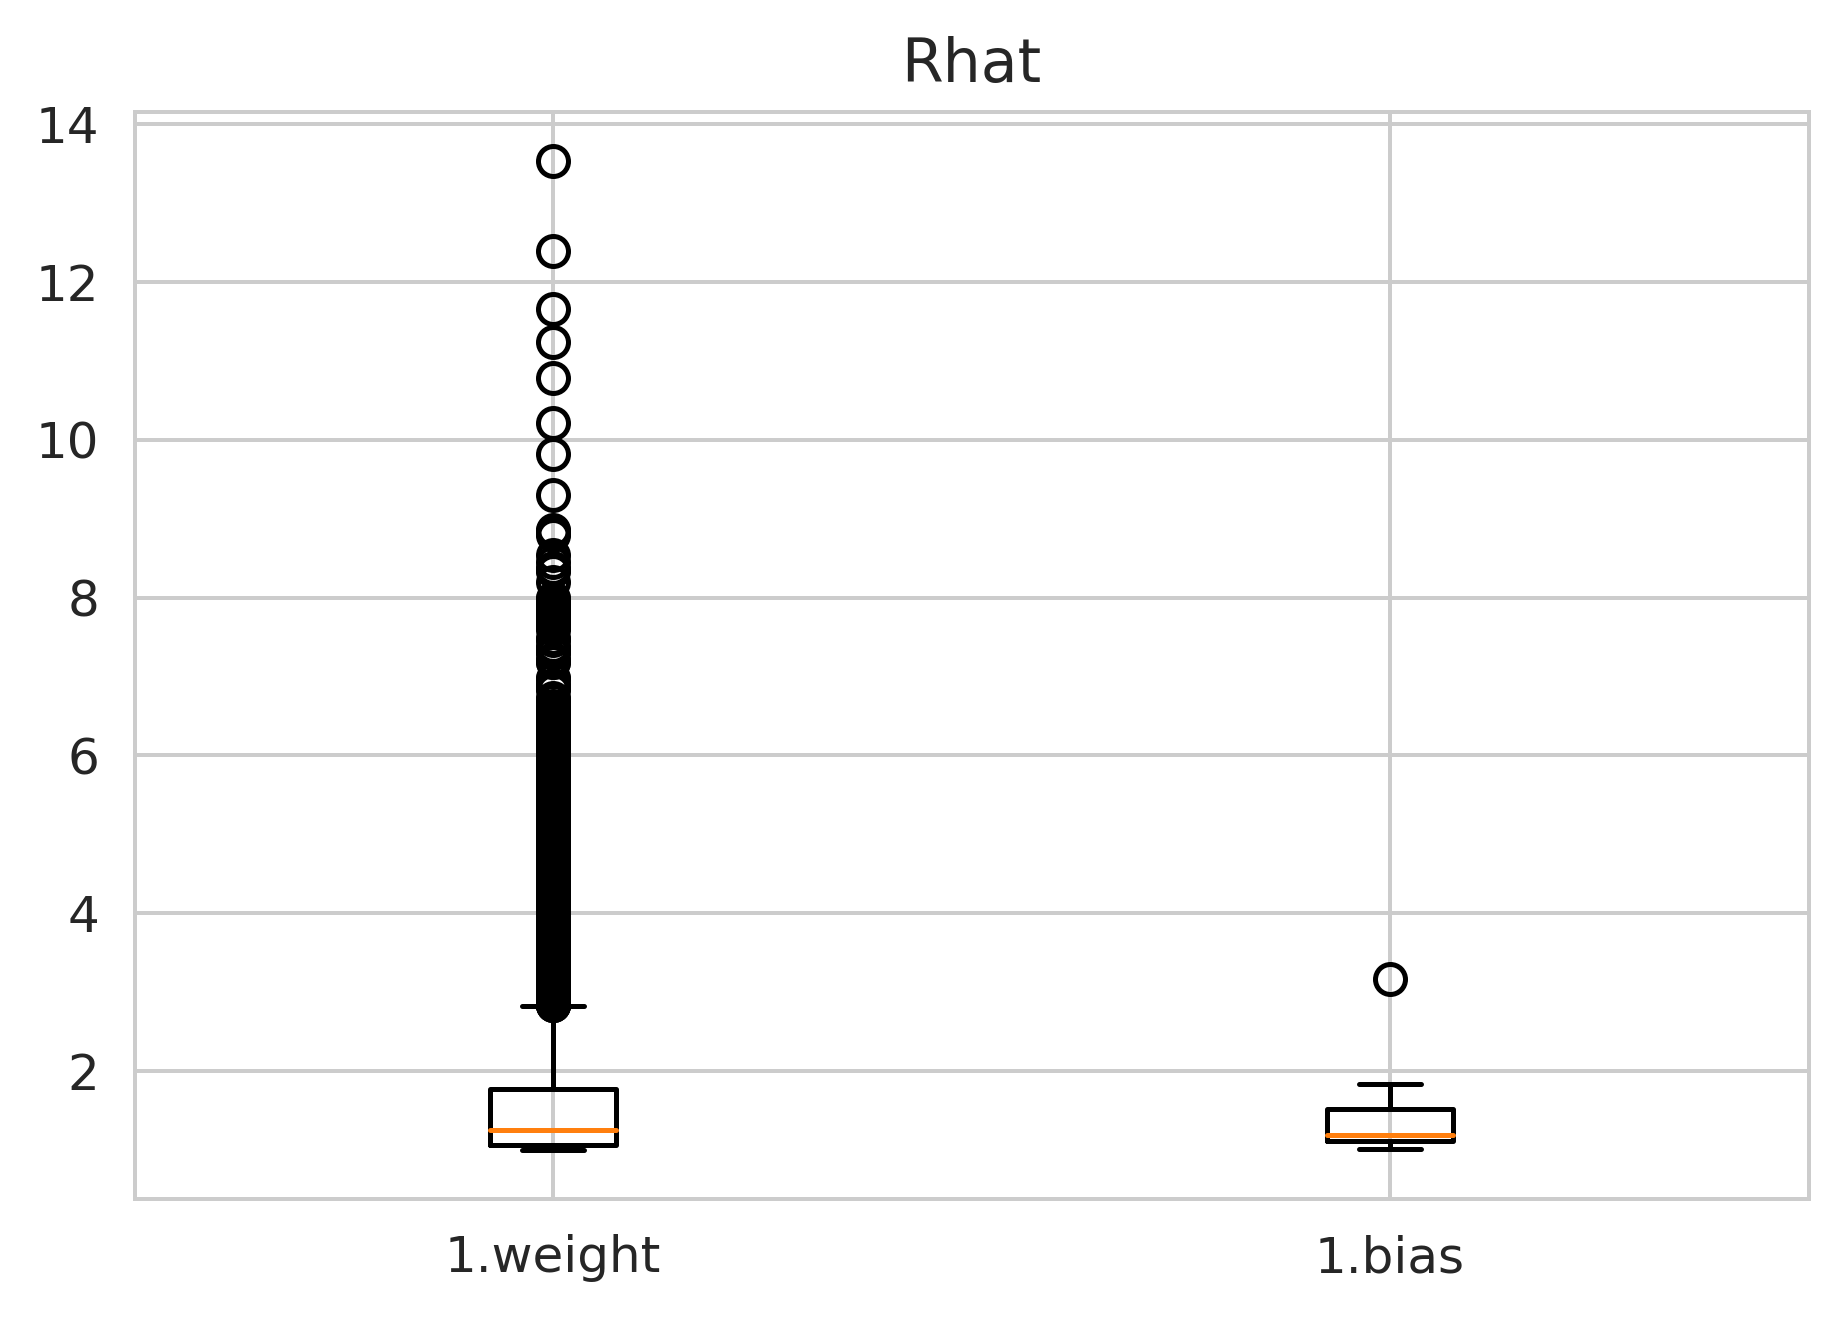

In [36]:
import seaborn as sns

labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhar_hierarchical_softmax.pdf', bbox_inches='tight')

In [37]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}

In [38]:
median_ess_hierarchical={var:np.median(ess[var]) for var in ess}

In [39]:
median_ess_hierarchical

{'1.weight': 13.89723, '1.bias': 12.109646}

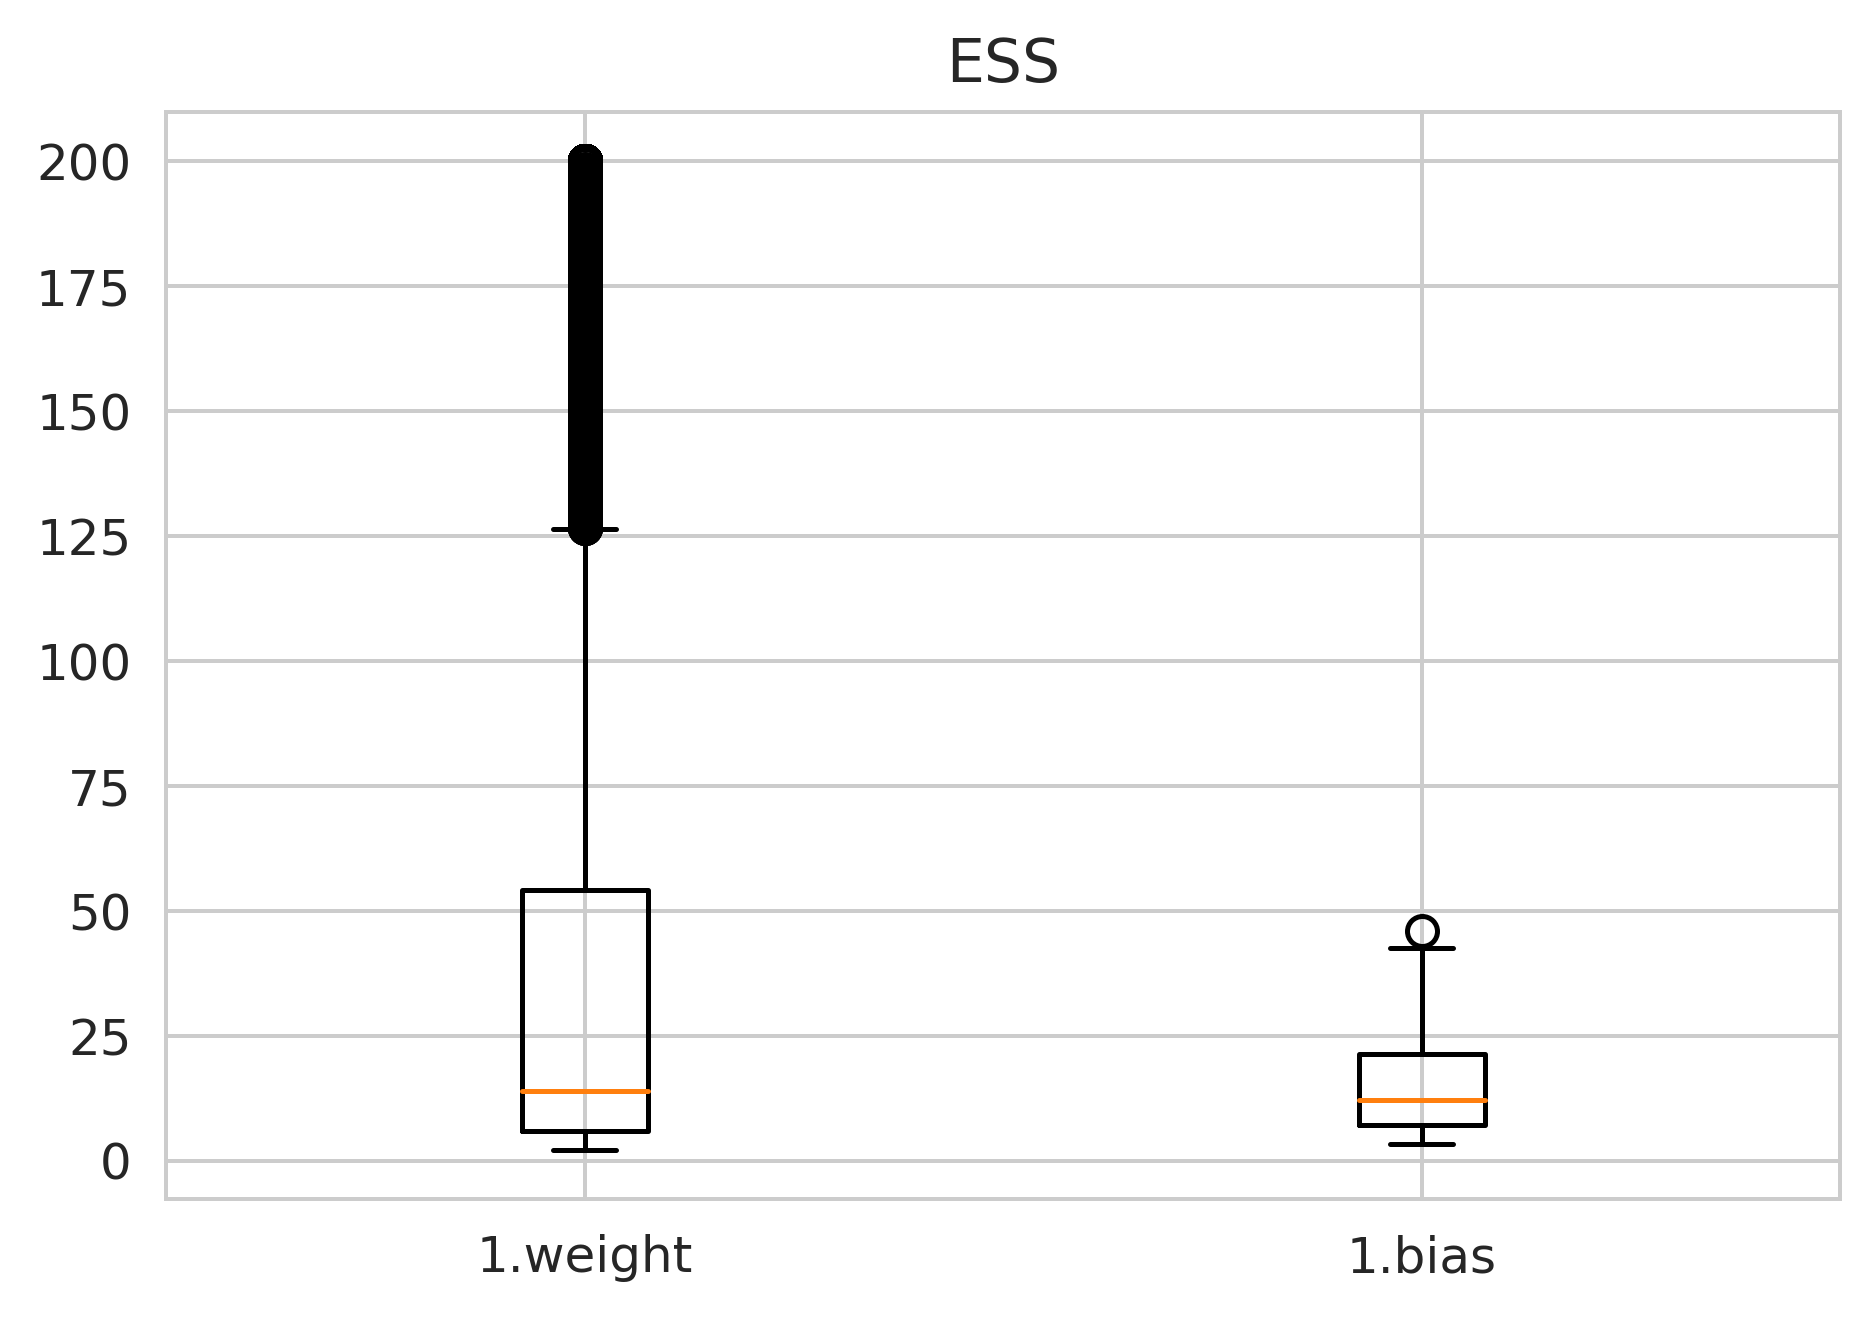

In [40]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_hierarchical_softmax.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Potential Scale Reduction (Rhat)')

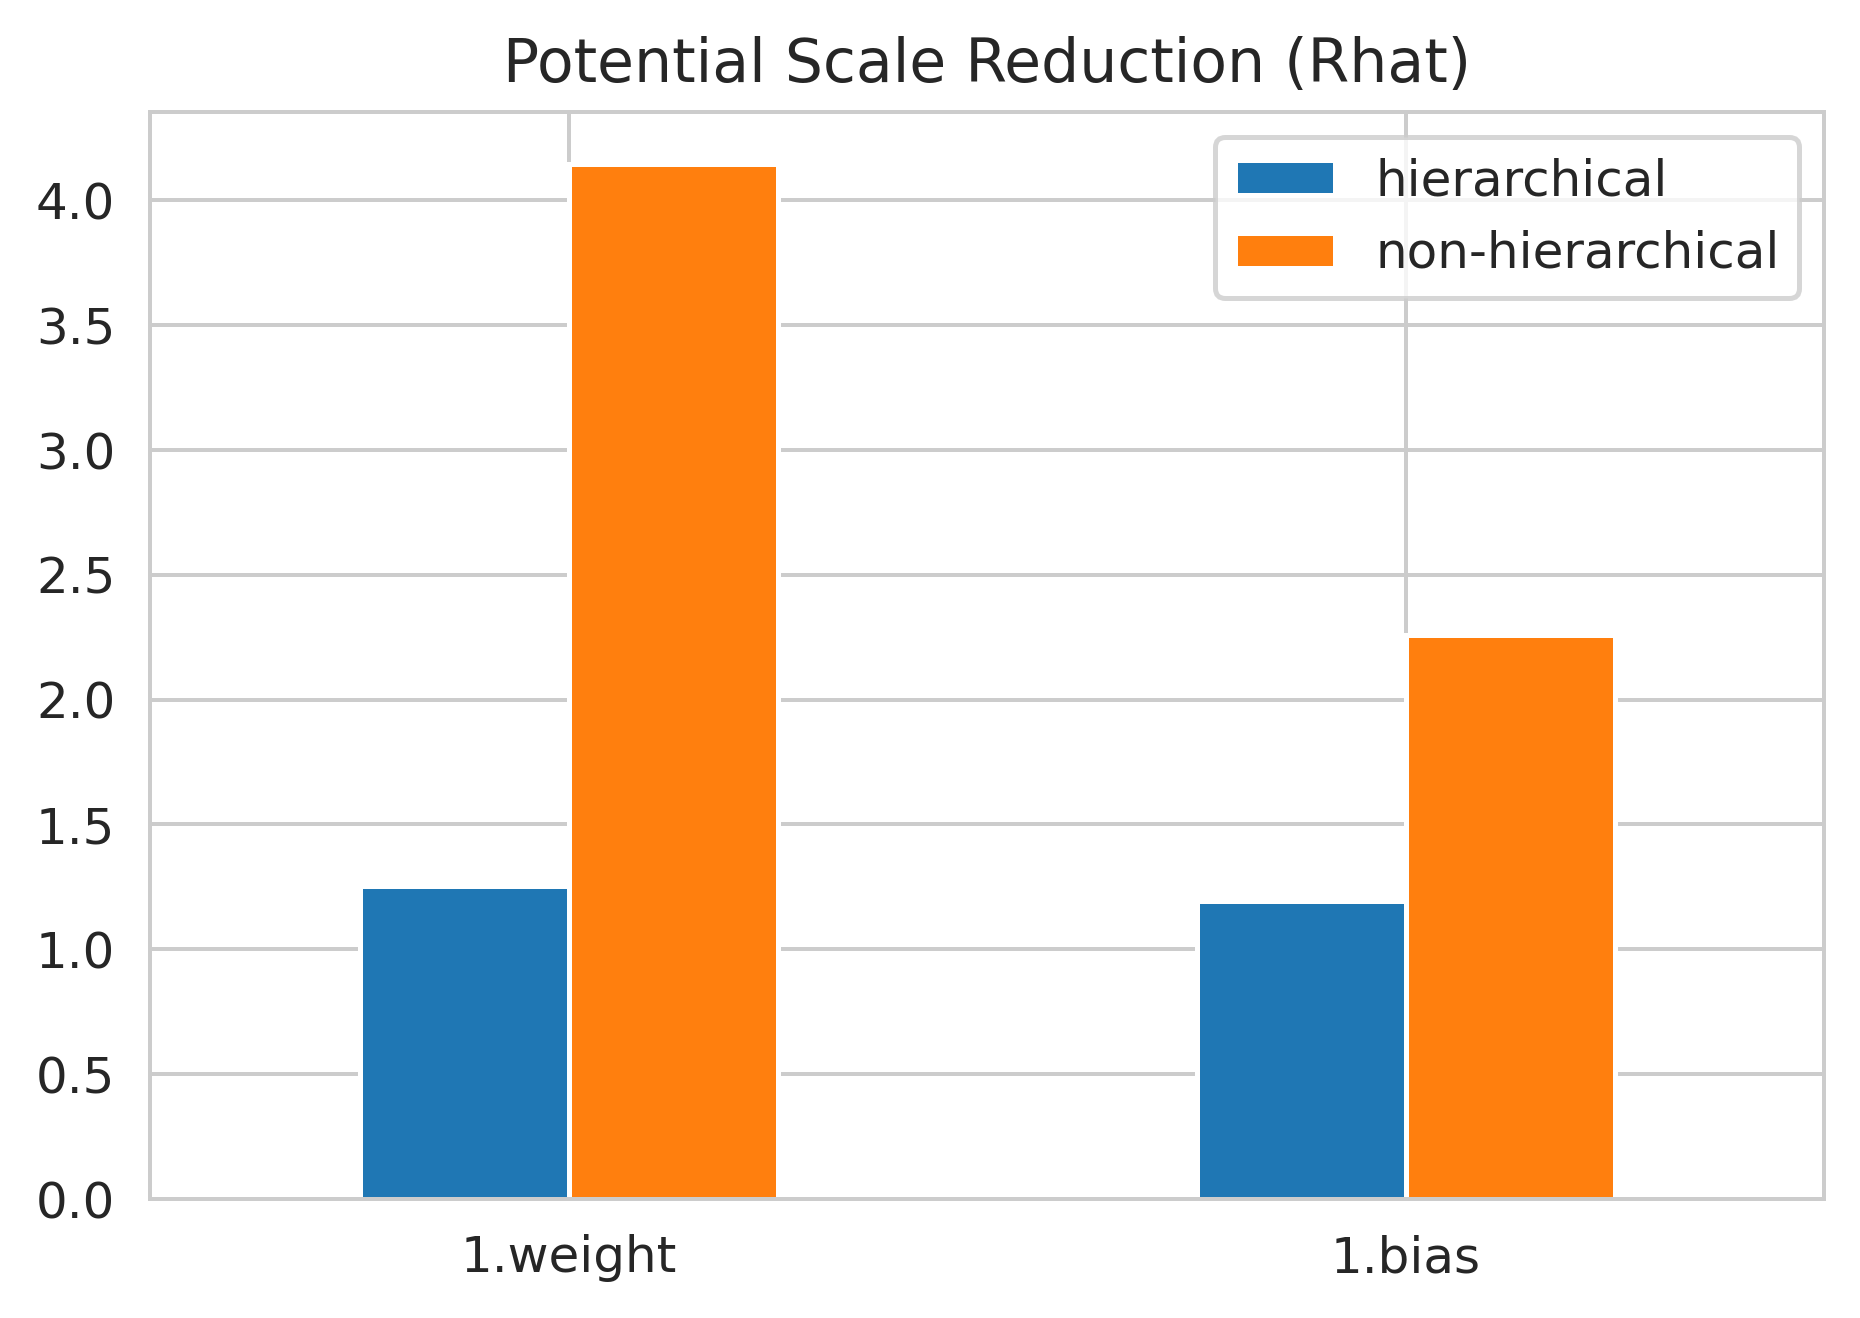

In [43]:
import pandas as pd

hierarchical=median_rhat_hierarchical.values()
flat=median_rhat_flat.values()
index = median_rhat_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Potential Scale Reduction (Rhat)')

Text(0.5, 1.0, 'ESS')

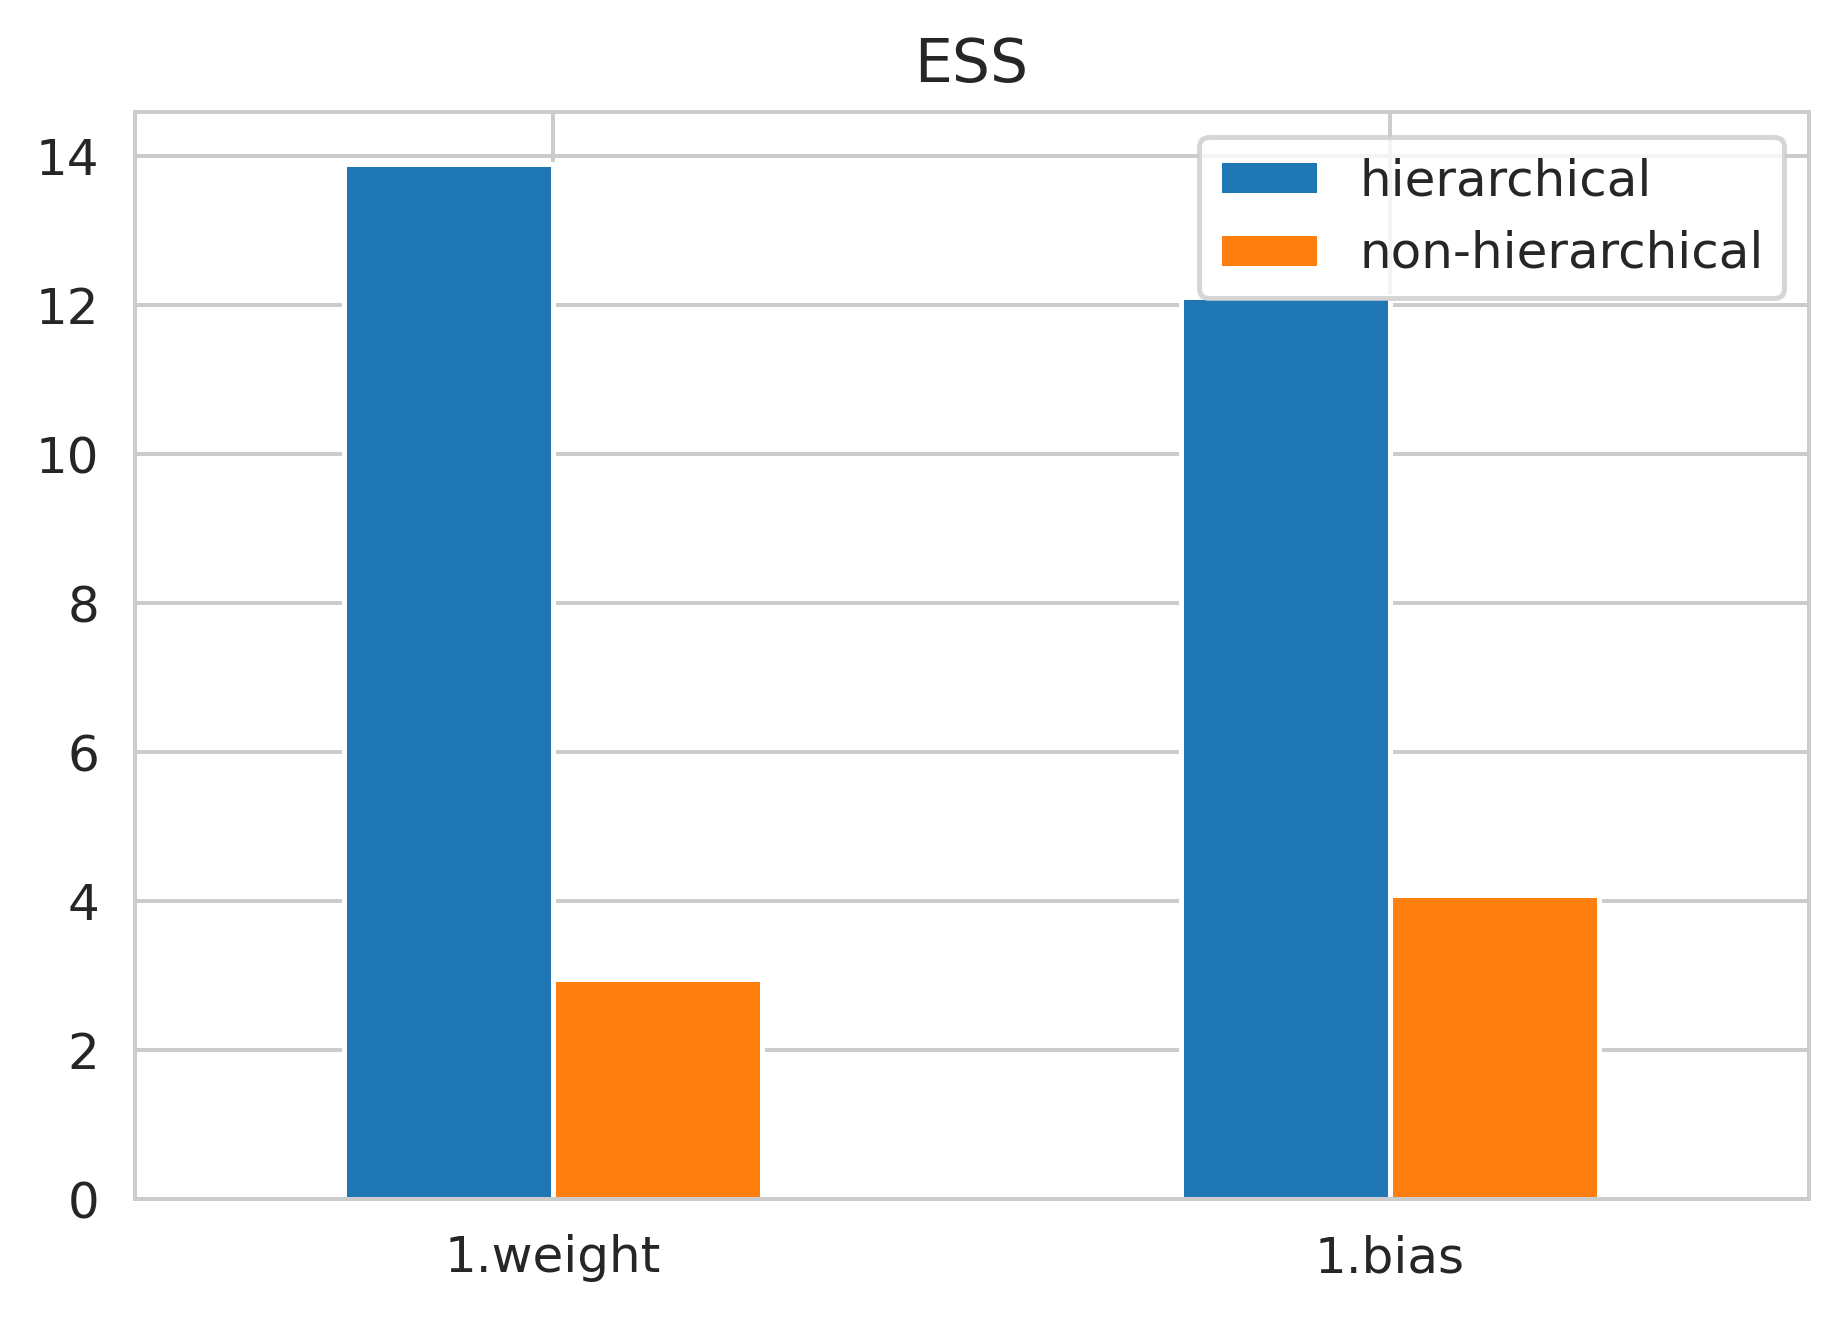

In [44]:
hierarchical=median_ess_hierarchical.values()
flat=median_ess_flat.values()
index = median_ess_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('ESS')